[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/simple_rnn.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Simple Recunrrent Neural Networks (RNNs) for sequence prediction

TO DO

In [2]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/rnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

import pandas as pd
import matplotlib.pyplot as plt
from keras import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Data preparation

 

First few rows of the dataset:
           day_type    rail
date                       
2001-01-01        U  126455
2001-01-02        W  501952
2001-01-03        W  536432
2001-01-04        W  550011
2001-01-05        W  557917
First few rows of the dataset after scaling and one-hot encoding:
                rail  day_type_A  day_type_U  day_type_W
date                                                    
2001-01-01 -0.816717           0           1           0
2001-01-02 -0.147961           0           0           1
2001-01-03 -0.086552           0           0           1
2001-01-04 -0.062368           0           0           1
2001-01-05 -0.048288           0           0           1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 6         
                                                                 
Total params: 6 (24.00 B

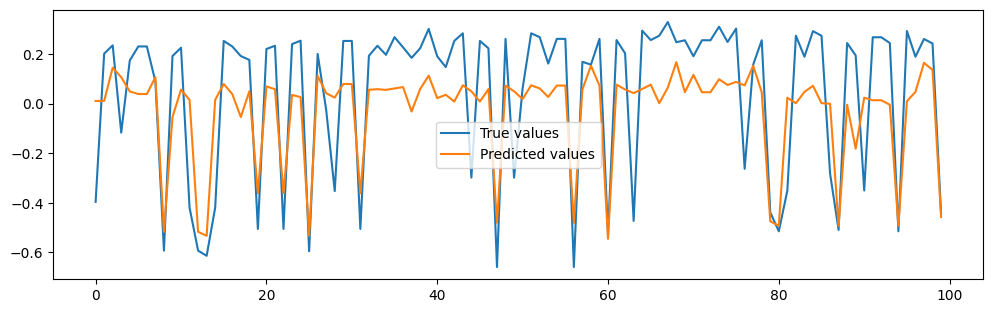

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1012/1012 [==============================] - 5s 5ms/step - loss: 0.0639 - mae: 0.2881 - mape: 55.2890
Test MAE: 746799.
Test MAPE: 55.29.
1012/1012 [==============================] - 7s 7ms/step


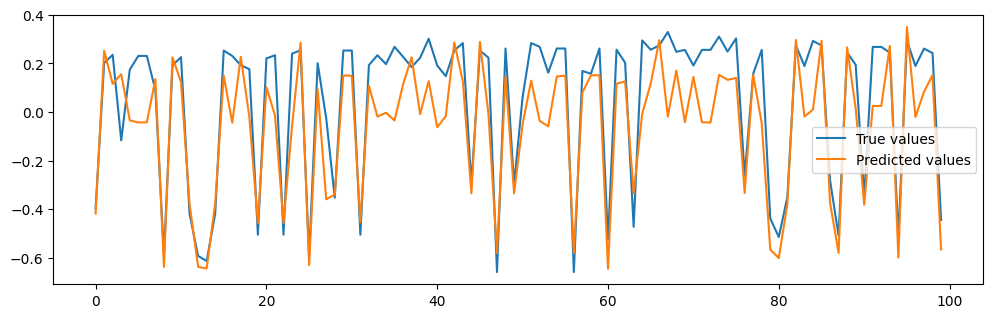

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          1184      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5377 (21.00 KB)
Trainable params: 5377 (21.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1012/1012 [==============================] - 11s 11ms/step - loss: 0.1190 - mae: 0.4346 - mape: 85.2149
Test MAE: 829045.
Test MAPE: 85.21.
1012/10

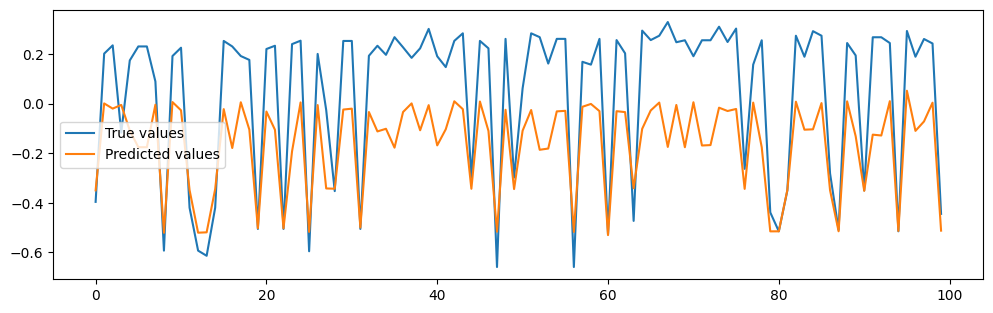

In [3]:
## LOAD THE DATA

dataset = pd.read_csv('data/transit.csv', parse_dates=['service_date'])  # parse_dates converts the column to datetime
# we will use the number of passengers for the train as the target variable, so bus and total_rides columns are not necessary
dataset = dataset.drop(columns=['bus', 'total_rides'])
# rename the rail_boardings column to rail and the service_date column to date
dataset = dataset.rename(columns={"rail_boardings": "rail", "service_date": "date"})
# remove duplicates
dataset = dataset.drop_duplicates()
# sort by date (ascending) and set the date as the index of the dataframe
dataset = dataset.sort_values("date").set_index("date")
# display the first few rows of the dataset
print("First few rows of the dataset:")
print(dataset.head())


# Let's plot the number of train passengers for the first semester months of 2001
#dataset["2001-01":"2001-06"].plot(grid=True, marker=".", figsize=(12, 3.5))
#plt.show()

# The default activation function for the RNN is the hyperbolic tangent (tanh) function,
# which outputs values between -1 and 1. A simple RNN uses the output as part of the input for the next time step.
# Therefore, we need to scale the data to be between -1 and 1. We use the MinMaxScaler from scikit-learn to scale the data.

# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['rail'] = scaler.fit_transform(dataset[['rail']])
# convert the date_type column to a one-hot encoded column
dataset = pd.get_dummies(dataset, columns=["day_type"])
# map True to 1 and False to 0
dataset = dataset.astype({"day_type_A": int, "day_type_U": int, "day_type_W": int})
print("First few rows of the dataset after scaling and one-hot encoding:")
print(dataset.head())

## SPLIT THE DATA INTO TRAINING, VALIDATION AND TESTING SETS

train_ds = dataset[:"2015-12"]
val_ds = dataset["2016-01":"2018-12"]
test_ds = dataset["2019-01":]

def create_variable_time_series_dataset(dataset_p: pd.DataFrame, length_from_p: int, length_to_p: int) \
        -> (list, list):
    """
    Create a variable length time series dataset
    :param dataset_p: the original dataset with the time series
    :param length_from_p: the minimum length of the time series X set
    :param length_to_p: the maximum length of the time series X set
    :return: (X, y) where X is the time series and y is the target variable
    """
    X, y = [], []
    for i in range(0, len(dataset_p)):
        series_length = np.random.randint(length_from_p, length_to_p + 1)
        if i + series_length < len(dataset_p):
            X.append(np.array(dataset_p.iloc[i:i + series_length][['rail', 'day_type_A', 'day_type_U', 'day_type_W']].values))
            y.append(dataset_p.iloc[i + series_length]['rail'])
        else:
            break
    return X, y


length_from, length_to = 40, 60
X_train, y_train = create_variable_time_series_dataset(train_ds, length_from, length_to)
X_val, y_val = create_variable_time_series_dataset(val_ds, length_from, length_to)
X_test, y_test = create_variable_time_series_dataset(test_ds, length_from, length_to)


# Select sequences of random length between 30 and 60 days using tf.keras.utils.timeseries_dataset_from_array


def X_y_to_tensor_slices(X_p: list, y_p: list) -> tf.data.Dataset:
    # Convert to TensorFlow Dataset
    return tf.data.Dataset.from_generator(
        lambda: zip(X_p, y_p),
        output_signature=(
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),  # X has shape [None, 5]: None for variable sequence length, and 5 for the number of features in each timestep
            tf.TensorSpec(shape=(), dtype=tf.float32)          # y is a scalar
        )
    )

train_set_tf = X_y_to_tensor_slices(X_train, y_train)
val_set_tf = X_y_to_tensor_slices(X_val, y_val)
test_set_tf = X_y_to_tensor_slices(X_test, y_test)

# Batch each sequence individually (batch of 1) to allow variable-length input
# (mandatory for training RNNs with variable-length sequences (not very common)).
# At inference, any length can be used, even though the model was trained with a specific length.
train_set_tf = (train_set_tf.batch(1)  # organizes the dataset into batches:
                # adds a new dimension batch-size to the dataset, grouping elements into batches
                # batch size is 1 to allow for variable length sequences
                .prefetch(1))  # prefetches the next batch while training on the current batch (pipeline parallelism)
                        # it is set to 1 to prefetch 1 batch while training on another 1 batch

val_set_tf = val_set_tf.batch(1).prefetch(1)
test_set_tf = test_set_tf.batch(1).prefetch(1)

# Define the model
simple_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 4])  # None = variable length sequence, 4 = number of features in each timestep
])
print(simple_model.summary())

def train_model(model: Model, train_set_p: tf.data.Dataset, val_set_p: tf.data.Dataset, learning_rate: float, epochs: int) \
        -> tf.keras.callbacks.History:
    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    # huber loss is less is useful for time series data
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae', 'mape'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=5, restore_best_weights=True)
    history = model.fit(train_set_p, validation_data=val_set_p, epochs=epochs,
                        batch_size=1, callbacks=[early_stopping_cb])
    return history


epochs = 1
train_model(simple_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
test_loss, test_mae, test_mape = simple_model.evaluate(test_set_tf)
# The test MAE is scaled, so we need to inverse the scaling to get the actual value.
# Since the output is a 2d array (bath_size, y features), we need to select the first element of the first element of the array.
print(f"Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}.")
print(f"Test MAPE: {test_mape:.2f}.")


def plot_predictions(y_test_p: np.array, y_pred_p: np.array, n_instances: int):
    """
    Plot the first 100 instances of y_pred vs y_test
    :param y_test_p: the true values
    :param y_pred_p: the predicted values
    """
    plt.figure(figsize=(12, 3.5))
    plt.plot(y_test_p[:n_instances], label="True values")
    plt.plot(y_pred_p[:n_instances], label="Predicted values")
    plt.legend()
    plt.show()


n_instances_to_plot = 100
y_pred = simple_model.predict(test_set_tf)
plot_predictions(y_test, y_pred, n_instances_to_plot)


## MULTIPLE SIMPLE RECURRENT NEURONS

# The model is not very accurate, but it is a simple model. We can try to improve the model by adding a layer of simple RNNs.
# Instead of one simple recurrent neuron, we can add 32 simple recurrent neurons to the model.
# Since the output has to be a scalar, we need to add a Dense layer with one neuron at the end of the model.

multi_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print(multi_model.summary())

train_model(multi_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
test_loss, test_mae, test_mape = multi_model.evaluate(test_set_tf)
print(f"Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}.")
print(f"Test MAPE: {test_mape:.2f}.")

y_pred = multi_model.predict(test_set_tf)
plot_predictions(y_test, y_pred, n_instances_to_plot)


## DEEP RNN

# We can also try to improve the model by adding more layers to the model.
# We can add three layers of simple RNNs with 32 neurons each.
# Each layer will return the output of each time step, so they can be stacked.
# To that aim we set return_sequences=True.
# We can also add a Dense layer with one neuron at the end of the model.


deep_model = tf.keras.Sequential([
    # return_sequences=True is used to return the output of each time step, not just the last one
    # in this way, the next layer can process the output of each time step (they can be stacked)
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print(deep_model.summary())

train_model(deep_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
test_loss, test_mae, test_mape = deep_model.evaluate(test_set_tf)
print(f"Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}.")
print(f"Test MAPE: {test_mape:.2f}.")

y_pred = deep_model.predict(test_set_tf)
plot_predictions(y_test, y_pred, n_instances_to_plot)


## QUESTIONS:
# 1. Are model preformed being improved by adding more complexity/parameters?
# 2. Why?
# 3. Do you think that will always be the case?

 